In [1]:
cd D:/Saarbrucken/EDA_Research/vae-disentanglement/disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


In [2]:
import numpy as np
import pandas as pd
import seaborn, time
import torch
from torch import nn
#from pomegranate import BayesianNetwork
#from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
#from common.known_datasets import CorrelatedDSpritesDataset


In [3]:
seaborn.set_style('whitegrid')

In [4]:
from common.special_modules import SimpleGNNLayer, SupervisedRegulariser

def _init_gnn(z_dim, dag_levels, ofd, adj_mat):
    
    in_node_feat_dim, out_node_feat_dim = z_dim * 2, z_dim * 2
    
    gnn_layers = [SimpleGNNLayer(ofd, out_node_feat_dim, adj_mat, is_final_layer=False)]
    for d in range(1, dag_levels):    
        gnn_layers.append(SimpleGNNLayer(in_node_feat_dim, out_node_feat_dim, adj_mat, is_final_layer= d == dag_levels - 1))
        
    return nn.Sequential(*gnn_layers)

print(_init_gnn(2, 4, 9, torch.zeros(5,5)))

Sequential(
  (0): Linear(in_features=9, out_features=4, bias=True) is_final_layer=False
  (1): Linear(in_features=4, out_features=4, bias=True) is_final_layer=False
  (2): Linear(in_features=4, out_features=4, bias=True) is_final_layer=False
  (3): Linear(in_features=4, out_features=4, bias=True) is_final_layer=True
)


In [4]:
def sanitize_celeb_attr_data(unsanitize_attrs_file):
    
    attr_list = []
    
    unsanitize_attrs = open(unsanitize_attrs_file,'r').readlines()
    
    for a in unsanitize_attrs:
        attr_line = a.strip('\n').split(' ')
        attrs_sanitized = [attr for attr in attr_line if attr != '']
        attr_list.append(attrs_sanitized)
        
    with open('/home/c01muya/vae-disentanglement/datasets/celeba/list_attr_celeba_sanitized.txt','w') as list_attr_celeb_sen:
        for attr_line in attr_list:
            list_attr_celeb_sen.write(
                ",".join(attr_line) + "\n"
            )

In [5]:
#sanitize_celeb_attr_data("/home/c01muya/vae-disentanglement/datasets/celeba/list_attr_celeba.txt")

In [5]:
celeb_attrs = pd.read_csv(r"D:/Saarbrucken/EDA_Research/vae-disentanglement/datasets/celeba/list_attr_celeba_sanitized.txt", 
                          sep=",", encoding='ascii')
celeb_attrs.drop('Image_ID', axis='columns', inplace=True)
celeb_attrs.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


## In the following 2 cells we condense binary attributes related to Hair Color and Hair Type into 2 categorical attributes

In [6]:

hair_color_conditions = [
    celeb_attrs['Black_Hair'] == 1,
    celeb_attrs['Brown_Hair'] == 1,
    celeb_attrs['Blond_Hair'] == 1,
    celeb_attrs['Gray_Hair']  == 1,
    (celeb_attrs['Black_Hair'] != 1) & (celeb_attrs['Brown_Hair'] != 1) & (celeb_attrs['Blond_Hair'] != 1) & (celeb_attrs['Gray_Hair']  != 1)
]

hair_color_values = ['Black', 'Brown', 'Blond', 'Gray', 'Unknown']
celeb_attrs['Hair_Color'] = np.select(hair_color_conditions, hair_color_values)
#celeb_attrs[ ['Hair_Color','Black_Hair', 'Brown_Hair', 'Blond_Hair', 'Gray_Hair'] ]
celeb_attrs.drop(['5_o_Clock_Shadow', 'Black_Hair','Brown_Hair','Blond_Hair','Gray_Hair'], axis='columns', inplace=True)

In [7]:
hair_type_conditions = [
    celeb_attrs['Bald'] == 1,
    celeb_attrs['Bangs'] == 1,
    celeb_attrs['Straight_Hair'] == 1,
    celeb_attrs['Wavy_Hair']  == 1,
    (celeb_attrs['Bald'] != 1) & (celeb_attrs['Bangs'] != 1) & (celeb_attrs['Straight_Hair'] != 1) & (celeb_attrs['Wavy_Hair'] != 1)
]

hair_type_values = ['Bald', 'Bangs', 'Straight', 'Wavy','Unknown']

celeb_attrs['Hair_Type'] = np.select(hair_type_conditions, hair_type_values)
#celeb_attrs[ ['Hair_Type','Bald', 'Bangs', 'Straight_Hair', 'Wavy_Hair'] ]
celeb_attrs.drop(['Bald', 'Bangs', 'Straight_Hair', 'Wavy_Hair'], axis='columns', inplace=True)

In [8]:
celeb_attrs.head(10)

,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Big_Lips,Big_Nose,Blurry,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,...,Sideburns,Smiling,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,Hair_Color,Hair_Type
0,1,1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,-1,1,Brown,Straight
1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,1,Brown,Unknown
2,-1,-1,-1,1,-1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,1,Unknown,Wavy
3,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,1,-1,1,Unknown,Straight
4,1,1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,1,-1,-1,1,Unknown,Unknown
5,1,1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,-1,1,Brown,Wavy
6,-1,1,1,1,1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,1,Black,Straight
7,1,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,1,Black,Unknown
8,1,1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,-1,1,Unknown,Bangs
9,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,1,-1,-1,1,Unknown,Wavy


In [11]:
len(celeb_attrs.columns), celeb_attrs.columns.to_list()

(33,
 ['Arched_Eyebrows',
  'Attractive',
  'Bags_Under_Eyes',
  'Big_Lips',
  'Big_Nose',
  'Blurry',
  'Bushy_Eyebrows',
  'Chubby',
  'Double_Chin',
  'Eyeglasses',
  'Goatee',
  'Heavy_Makeup',
  'High_Cheekbones',
  'Male',
  'Mouth_Slightly_Open',
  'Mustache',
  'Narrow_Eyes',
  'No_Beard',
  'Oval_Face',
  'Pale_Skin',
  'Pointy_Nose',
  'Receding_Hairline',
  'Rosy_Cheeks',
  'Sideburns',
  'Smiling',
  'Wearing_Earrings',
  'Wearing_Hat',
  'Wearing_Lipstick',
  'Wearing_Necklace',
  'Wearing_Necktie',
  'Young',
  'Hair_Color',
  'Hair_Type'])

In [9]:
celeb_attrs_mat = celeb_attrs.to_numpy()
print(celeb_attrs_mat.shape)

(202599, 33)


In [11]:
#celeb_attrs_mat_subset = celeb_attrs_mat[:10000,:]
#print(celeb_attrs_mat_subset.shape)

In [18]:
celeb_col_names = celeb_attrs.columns.to_list()
model = BayesianNetwork.from_samples(celeb_attrs_mat, 
                                     state_names=celeb_col_names, 
                                     algorithm='chow-liu',
                                     root=celeb_col_names.index('Male'))
print(model.structure)

((27,), (11,), (4,), (0,), (13,), (1,), (31,), (4,), (7,), (1,), (17,), (27,), (27,), (), (24,), (17,), (14,), (13,), (12,), (1,), (11,), (32,), (11,), (17,), (12,), (13,), (31,), (13,), (13,), (13,), (1,), (13,), (27,))


In [13]:
contents = {
    'adj_mat': [
    (27,), (11,), (4,), (0,), (13,), (1,), (31,), (4,), (7,), (1,), (17,), 
    (27,), (27,), (), (24,), (17,), (14,), (13,), (12,), (1,), (11,), (32,), 
    (11,), (17,), (12,), (13,), (31,), (13,), (13,), (13,), (1,), (13,), (27,)
],

'node_labels' : celeb_attrs.columns.to_list()
}

import pickle

pickle.dump(contents, open("D:\\Saarbrucken\\EDA_Research\\vae-disentanglement\\adjacency_matrices\\celeba_labeled.pkl", "wb"))


In [19]:
#%matplotlib inline

model.plot("../reports/learned-dag-male-root.pdf")

In [ ]:
celeb_attrs = pd.read_csv("/home/c01muya/vae-disentanglement/datasets/celeba/list_attr_celeba_sanitized.txt", 
                          sep=",", encoding='ascii')
celeb_attrs.drop('Image_ID', axis='columns', inplace=True)
celeb_attrs.head()

In [5]:
import os

os.environ['DISENTANGLEMENT_LIB_DATA'] = '../datasets/'
print(os.environ.get('DISENTANGLEMENT_LIB_DATA','.'))
corr_dsprites = CorrelatedDSpritesDataset(correlation_strength=0.2, seed=123, split='train')

../datasets/
Initialize [CorrelatedDSpritesDataset] with 737280 examples. Shape (737280, 64, 64).


In [18]:
factors, Xs = corr_dsprites.dataset.sample(10000, random_state=corr_dsprites.random_state)

In [19]:
factors.shape,Xs.shape

((10000, 5), (10000, 64, 64, 1))

In [22]:

dsprites_model = BayesianNetwork.from_samples(factors, 
                                     state_names=['shape','scale','orientation','posX', 'posY'], 
                                     algorithm='exact')
print(dsprites_model.structure)

((), (), (3,), (), ())


In [21]:
dsprites_model.plot("../reports/dsprites-dag.pdf")

ValueError: must have matplotlib and pygraphviz installed for visualization

In [4]:
from common import dag_utils

In [5]:
dag_utils.get_dag_layers(
    ((), (), (3,), (), ())
)

[[0, 1, 3, 4], [2]]

In [6]:
dag_utils.get_layer_mask([0, 1, 3, 4], [2], 2, ((), (), (3,), (), ()))

array([[0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 0.]], dtype=float32)

In [7]:
from models.cs_vae import ConceptStructuredVAE
from collections import namedtuple
ModelParams = namedtuple('ModelParams', ["adjacency_matrix", "interm_unit_dim","z_dim", "in_channels",
                                               "image_size", "batch_size", "root_dim", "decoder"])
network_args = ModelParams(
    [(), (), (3,), (), ()],
    2,
    10,
    1,
    64, 64, 2, ['SimpleConv64']
)
csvae = ConceptStructuredVAE(network_args)

Model Initialized


In [8]:
csvae.dag_layer_nodes[0]

[0, 1, 3, 4]

In [9]:
csvae

ConceptStructuredVAE(
  (bottom_up_networks): ModuleList(
    (0): SimpleConv64(
      (main): Sequential(
        (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): ReLU(inplace=True)
        (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (9): ReLU(inplace=True)
        (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Flatten3D()
        (13): Linear(in_features=256, out_features=2, bias=True)
      )
    )
    (1): SimpleFCNNEncoder(
      (main): Sequential(
        (0): Linear(in_features=2, out_features=4, bias=True)


In [10]:
import torch

cd = torch.device('cuda:3')
csvae = csvae.to(cd)
inp = torch.rand(1,1,64,64, device = cd)
I = csvae(inp, current_device=cd)

In [12]:
I

{'x_recon': tensor([[[[0.5653, 0.5681, 0.5693,  ..., 0.5695, 0.5709, 0.5685],
           [0.5658, 0.5685, 0.5714,  ..., 0.5696, 0.5722, 0.5680],
           [0.5668, 0.5695, 0.5698,  ..., 0.5720, 0.5703, 0.5682],
           ...,
           [0.5684, 0.5692, 0.5713,  ..., 0.5721, 0.5686, 0.5688],
           [0.5686, 0.5673, 0.5688,  ..., 0.5681, 0.5668, 0.5668],
           [0.5678, 0.5663, 0.5667,  ..., 0.5668, 0.5654, 0.5673]]]],
        device='cuda:3', grad_fn=<SigmoidBackward>),
 'td_net_outs': [{'mu_p': tensor([[0., 0., 0., 0.]], device='cuda:3'),
   'sigma_p': tensor([[0., 0., 0., 0.]], device='cuda:3'),
   'mu_q': tensor([[-0.4443, -0.9264, -0.4671,  0.6194]], device='cuda:3',
          grad_fn=<SplitBackward>),
   'sigma_q': tensor([[ 1.0912, -1.3954,  0.1581,  0.9061]], device='cuda:3',
          grad_fn=<SplitBackward>),
   'z': tensor([[-3.2446, -0.6126, -1.9193, -1.2267]], device='cuda:3',
          grad_fn=<AddBackward0>)},
  {'mu_p': tensor([[0.]], device='cuda:3', grad_fn=<

In [72]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
from common.utils import CenteredNorm
import numpy as np

In [73]:
T = torch.randn(1, 10, 10)
I = torch.eye(10).unsqueeze(0)
Tm = T.mul(I)
TI = torch.cat([T, Tm], dim=2).permute(1,2,0).numpy()

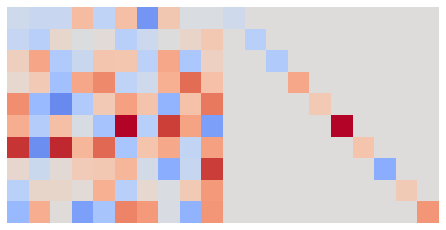

In [89]:
fig, ax = plt.subplots()
ax.imshow(TI, cmap=cm.coolwarm, norm=CenteredNorm())
ax.axis('off')
fig.tight_layout(pad=0)
ax.margins(0)

fig.canvas.draw()
buf = fig.canvas.buffer_rgba()
X = np.asarray(buf)#[:,:,0:3]

In [92]:
ax.gcf()

AttributeError: 'AxesSubplot' object has no attribute 'gcf'

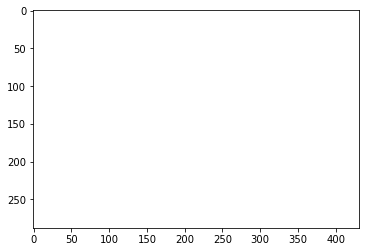

In [91]:
fig, ax = plt.subplots()
#ax.axis('off')
#fig.tight_layout(pad=0)
ax.imshow(X)
#fig.canvas.draw()

In [93]:
plt.imshow


<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

In [95]:
F=plt.figure()

<Figure size 432x288 with 0 Axes>

In [101]:
10 * 2 * (1/2.54)

7.874015748031495

In [105]:
plt.gcf().__dict__

{'_stale': True,
 'stale_callback': None,
 'figure': None,
 '_transform': None,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_contains': None,
 '_rasterized': None,
 '_agg_filter': None,
 '_mouseover': False,
 'eventson': False,
 '_oid': 0,
 '_propobservers': {},
 '_remove_method': None,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 'callbacks': <matplotlib.cbook.CallbackRegistry at 0x2574cf0c310>,
 'bbox_inches': Bbox([[0.0, 0.0], [6.0, 4.0]]),
 'dpi_scale_trans': <matplotlib.transforms.Affine2D at 0x2574cf0c5e0>,
 '_dpi': 72.0,
 'bbox': <matplotlib.transforms.TransformedBbox at 0x2574cf0c6a0>,
 'transFigure': <matplotlib.transforms.BboxTransformTo at 0x2574cf0cca0>,
 'patch': <matplotlib.patches.Rectangle at 0x2574cf0ca90>,
 'canvas': <matplotlib.backends.bac

<Figure size 432x288 with 0 Axes>